In [1]:
import SimpleITK as sitk
import numpy as np
import SimpleITK as sitk
import six
import cv2
import glob
import sys, os
import time
import tqdm
from tqdm import tqdm_notebook
from radiomics import firstorder, getTestCase, glcm, glrlm, glszm, imageoperations, shape, shape2D

%matplotlib inline
import matplotlib.pyplot as plt

import csv   
import pandas as pd

In [2]:
Img_dir = 'C:\\Users\\user\\Desktop\\crop\\normal'

In [3]:
Img_list = sorted(glob.glob( (Img_dir + '/*')))

In [4]:
print(len(Img_list))

1984


In [5]:
# from skimage import draw
# import numpy as np
# def poly2mask(shape):
#     mask = np.ones(shape, dtype=np.bool)
#     return mask

# mask = poly2mask((256,256))

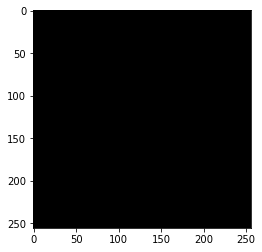

In [6]:
# plt.imshow(mask, cmap='gray')
# plt.show()

In [1]:
# mask = mask*1
# mask = np.uint8(mask)
# print(mask.dtype)
# print(np.max(mask))
# print(np.min(mask))
# print(mask.shape)

NameError: name 'mask' is not defined

In [8]:
from skimage.transform import resize

# def rgb2gray(rgb):
#     return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

image = plt.imread(Img_list[0])
# image = rgb2gray(image)
image_img = cv2.resize(image,(256,256))
print(Img_list[0])
print(image_img.shape)
print(image_img.dtype)
print(type(image))

C:\Users\user\Desktop\crop\normal\N1_crop_image(0).jpg
(256, 256)
float64
<class 'numpy.ndarray'>


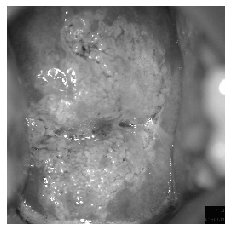

In [9]:
plt.imshow(image_img, cmap='gray')
plt.axis('off')
plt.show()

In [10]:
# mask_roi = sitk.GetImageFromArray(mask, isVector=False)
image = sitk.GetImageFromArray(image_img, isVector=False)

In [11]:
image

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x0000025FDC09D060> >

In [12]:
# mask_roi

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x0000025FDC09D1B0> >

In [13]:
# target = image_img * mask

print(image_img.shape)
# print(mask.shape)
# print(target.shape)

(256, 256)
(256, 256)
(256, 256)


In [14]:
# print(np.max(mask))
print(np.max(image_img))
# print(np.max(target))

1
254.45142499999997
254.45142499999997


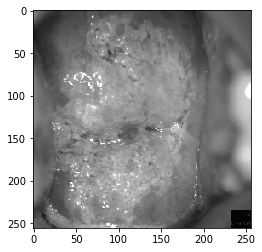

In [15]:
plt.imshow(image_img, cmap='gray')
plt.show()

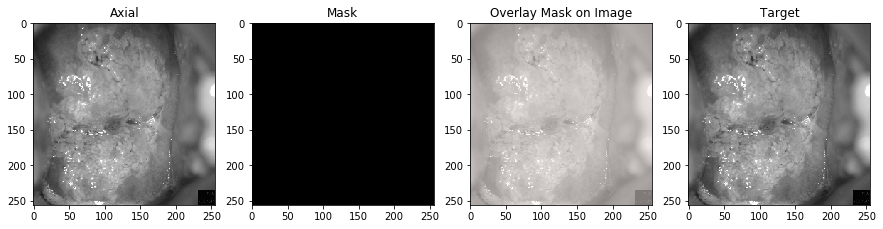

In [16]:
plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(image_img, cmap="gray")
plt.title("Axial")
plt.subplot(1,4,2)
# plt.imshow(mask, cmap="gray")        
# plt.title("Mask")
# plt.subplot(1,4,3)
# plt.imshow(image_img, cmap="gray")
# plt.imshow(mask, cmap="Reds", alpha=0.5)        
# plt.title("Overlay Mask on Image")
# plt.subplot(1,4,4)
# plt.imshow(target, cmap="gray")
# plt.title("Target")

plt.show()

In [17]:
applyLog = True
applyWavelet = True

# Setting for the feature calculation.
# Currently, resampling is disabled.
# Can be enabled by setting 'resampledPixelSpacing' to a list of 3 floats (new voxel size in mm for x, y and z)
settings = {'binWidth': 25,
            'interpolator': sitk.sitkBSpline,
            'resampledPixelSpacing': None}


#
# If enabled, resample image (resampled image is automatically cropped.
#
interpolator = settings.get('interpolator')
resampledPixelSpacing = settings.get('resampledPixelSpacing')
if interpolator is not None and resampledPixelSpacing is not None:
    image, mask = imageoperations.resampleImage(image, mask, **settings)

bb, correctedMask = imageoperations.checkMask(image, mask_roi)
if correctedMask is not None:
    mask = correctedMask
    
image, mask = imageoperations.cropToTumorMask(image, mask_roi, bb)

In [42]:
#
# Show the first order feature calculations       18
#

firstOrderFeatures = firstorder.RadiomicsFirstOrder(image, mask, **settings)

#firstOrderFeatures.enableFeatureByName('Mean', True)
firstOrderFeatures.enableAllFeatures()

print('Will calculate the following first order features: ')
for f in firstOrderFeatures.enabledFeatures.keys():
    print('  ', f)
    print(getattr(firstOrderFeatures, 'get%sFeatureValue' % f).__doc__)

print('Calculating first order features...')
results = firstOrderFeatures.execute()
print('done')
results_first_order = {}
print('Calculated first order features: ')
for (key, val) in six.iteritems(results):
    results_first_order.update({key : val})
    #print('  ', key, ':', val)
    
csv_first_order = pd.DataFrame.from_dict(results_first_order, orient='index')
csv_first_order.columns = ['Value']
csv_first_order.reset_index(level=0, inplace=True)
csv_first_order['Feature_ID'] = 'First_Order'
cols = csv_first_order.columns.tolist()
cols = cols[-1:] + cols[:-1]
csv_first_order = csv_first_order[cols]

Will calculate the following first order features: 
   10Percentile

    **5. 10th percentile**

    The 10\ :sup:`th` percentile of :math:`\textbf{X}`
    
   90Percentile

    **6. 90th percentile**

    The 90\ :sup:`th` percentile of :math:`\textbf{X}`
    
   Energy

    **1. Energy**

    .. math::
      \textit{energy} = \displaystyle\sum^{N_p}_{i=1}{(\textbf{X}(i) + c)^2}

    Here, :math:`c` is optional value, defined by ``voxelArrayShift``, which shifts the intensities to prevent negative
    values in :math:`\textbf{X}`. This ensures that voxels with the lowest gray values contribute the least to Energy,
    instead of voxels with gray level intensity closest to 0.

    Energy is a measure of the magnitude of voxel values in an image. A larger values implies a greater sum of the
    squares of these values.

    .. note::
      This feature is volume-confounded, a larger value of :math:`c` increases the effect of volume-confounding.
    
   Entropy

    **3. Entropy**

    .

In [43]:
csv_first_order.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
Feature_ID,First_Order,First_Order,First_Order,First_Order,First_Order,First_Order,First_Order,First_Order,First_Order,First_Order,First_Order,First_Order,First_Order,First_Order,First_Order,First_Order,First_Order,First_Order
index,10Percentile,90Percentile,Energy,Entropy,InterquartileRange,Kurtosis,Maximum,MeanAbsoluteDeviation,Mean,Median,Minimum,Range,RobustMeanAbsoluteDeviation,RootMeanSquared,Skewness,TotalEnergy,Uniformity,Variance
Value,81.6694,169.548,1.13923e+09,2.59834,51.9031,3.39447,254.451,29.4055,126.673,126.41,11.3907,243.061,21.0092,131.846,0.0657207,1.13923e+09,0.192624,1337.27


In [44]:
#
# Show GLCM features   24
#
glcmFeatures = glcm.RadiomicsGLCM(image, mask, **settings)
glcmFeatures.enableAllFeatures()

print('Will calculate the following GLCM features: ')
for f in glcmFeatures.enabledFeatures.keys():
    print('  ', f)
    print(getattr(glcmFeatures, 'get%sFeatureValue' % f).__doc__)
       
print('Calculating GLCM features...')
results = glcmFeatures.execute()
print('done')

results_GLCM = {}
for (key, val) in six.iteritems(results):
    results_GLCM.update({key : val})

'''print('Calculated GLCM features: ')
for (key, val) in six.iteritems(results_GLCM):
    print('  ', key, ':', val)'''
    
csv_GLCM = pd.DataFrame.from_dict(results_GLCM, orient='index')
csv_GLCM.columns = ['Value']
csv_GLCM.reset_index(level=0, inplace=True)
csv_GLCM['Feature_ID'] = 'GLCM'
cols = csv_GLCM.columns.tolist()
cols = cols[-1:] + cols[:-1]
csv_GLCM = csv_GLCM[cols]

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Will calculate the following GLCM features: 
   Autocorrelation

    **1. Autocorrelation**

    .. math::
      \textit{autocorrelation} = \displaystyle\sum^{N_g}_{i=1}\displaystyle\sum^{N_g}_{j=1}{p(i,j)ij}

    Autocorrelation is a measure of the magnitude of the fineness and coarseness of texture.
    
   ClusterProminence

    **3. Cluster Prominence**

    .. math::
      \textit{cluster prominence} = \displaystyle\sum^{N_g}_{i=1}\displaystyle\sum^{N_g}_{j=1}
      {\big( i+j-\mu_x-\mu_y\big)^4p(i,j)}

    Cluster Prominence is a measure of the skewness and asymmetry of the GLCM. A higher values implies more asymmetry
    about the mean while a lower value indicates a peak near the mean value and less variation about the mean.
    
   ClusterShade

    **4. Cluster Shade**

    .. math::
      \textit{cluster shade} = \displaystyle\sum^{N_g}_{i=1}\displaystyle\sum^{N_g}_{j=1}
      {\big(i+j-\mu_x-\mu_y\big)^3p(i,j)}

    Cluster Shade is a measure of the skewness and uniformity 

In [45]:
csv_GLCM.T

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Feature_ID,GLCM,GLCM,GLCM,GLCM,GLCM,GLCM,GLCM,GLCM,GLCM,GLCM,...,GLCM,GLCM,GLCM,GLCM,GLCM,GLCM,GLCM,GLCM,GLCM,GLCM
index,Autocorrelation,ClusterProminence,ClusterShade,ClusterTendency,Contrast,Correlation,DifferenceAverage,DifferenceEntropy,DifferenceVariance,Id,...,Imc2,InverseVariance,JointAverage,JointEnergy,JointEntropy,MCC,MaximumProbability,SumAverage,SumEntropy,SumSquares
Value,33.094,240.679,-0.248672,8.60202,0.33396,0.925233,0.235285,0.846467,0.27788,0.893758,...,0.979846,0.189992,5.57019,0.129085,3.57131,0.954064,0.208249,11.1404,3.26156,2.23399


In [46]:
#
# Show GLRLM features     16
#
glrlmFeatures = glrlm.RadiomicsGLRLM(image, mask, **settings)
glrlmFeatures.enableAllFeatures()

print('Will calculate the following GLRLM features: ')
for f in glrlmFeatures.enabledFeatures.keys():
    print('  ', f)
    print(getattr(glrlmFeatures, 'get%sFeatureValue' % f).__doc__)

print('Calculating GLRLM features...')
results = glrlmFeatures.execute()
print('done')

results_GLRLM = {}
for (key, val) in six.iteritems(results):
    results_GLRLM.update({key : val})

'''print('Calculated GLRLM features: ')
for (key, val) in six.iteritems(results_GLRLM):
    print('  ', key, ':', val)'''

csv_GLRLM = pd.DataFrame.from_dict(results_GLRLM, orient='index')
csv_GLRLM.columns = ['Value']
csv_GLRLM.reset_index(level=0, inplace=True)
csv_GLRLM['Feature_ID'] = 'GLRLM'
cols = csv_GLRLM.columns.tolist()
cols = cols[-1:] + cols[:-1]
csv_GLRLM = csv_GLRLM[cols]

Will calculate the following GLRLM features: 
   GrayLevelNonUniformity

    **3. Gray Level Non-Uniformity (GLN)**

    .. math::
      \textit{GLN} = \frac{\sum^{N_g}_{i=1}\left(\sum^{N_r}_{j=1}{\textbf{P}(i,j|\theta)}\right)^2}{N_r(\theta)}

    GLN measures the similarity of gray-level intensity values in the image, where a lower GLN value correlates with a
    greater similarity in intensity values.
    
   GrayLevelNonUniformityNormalized

    **4. Gray Level Non-Uniformity Normalized (GLNN)**

    .. math::
      \textit{GLNN} = \frac{\sum^{N_g}_{i=1}\left(\sum^{N_r}_{j=1}{\textbf{P}(i,j|\theta)}\right)^2}{N_r(\theta)^2}

    GLNN measures the similarity of gray-level intensity values in the image, where a lower GLNN value correlates with a
    greater similarity in intensity values. This is the normalized version of the GLN formula.
    
   GrayLevelVariance

    **8. Gray Level Variance (GLV)**

    .. math::
      \textit{GLV} = \displaystyle\sum^{N_g}_{i=1}\displaystyle\sum^

In [47]:
csv_GLRLM.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Feature_ID,GLRLM,GLRLM,GLRLM,GLRLM,GLRLM,GLRLM,GLRLM,GLRLM,GLRLM,GLRLM,GLRLM,GLRLM,GLRLM,GLRLM,GLRLM,GLRLM
index,GrayLevelNonUniformity,GrayLevelNonUniformityNormalized,GrayLevelVariance,HighGrayLevelRunEmphasis,LongRunEmphasis,LongRunHighGrayLevelEmphasis,LongRunLowGrayLevelEmphasis,LowGrayLevelRunEmphasis,RunEntropy,RunLengthNonUniformity,RunLengthNonUniformityNormalized,RunPercentage,RunVariance,ShortRunEmphasis,ShortRunHighGrayLevelEmphasis,ShortRunLowGrayLevelEmphasis
Value,2523.58,0.183852,2.6795,38.5511,63.8596,1880.91,3.25193,0.0408676,6.02307,2312.34,0.167322,0.20937,40.212,0.401449,17.3727,0.0147434


In [48]:
#
# Show GLSZM features   16
#
glszmFeatures = glszm.RadiomicsGLSZM(image, mask, **settings)
glszmFeatures.enableAllFeatures()

print('Will calculate the following GLSZM features: ')
for f in glszmFeatures.enabledFeatures.keys():
    print('  ', f)
    print(getattr(glszmFeatures, 'get%sFeatureValue' % f).__doc__)

print('Calculating GLSZM features...')
results = glszmFeatures.execute()
print('done')

results_GLSZM = {}
for (key, val) in six.iteritems(results):
    results_GLSZM.update({key : val})

'''print('Calculated GLSZM features: ')
for (key, val) in six.iteritems(results_GLSZM):
    print('  ', key, ':', val)'''
    
csv_GLSZM = pd.DataFrame.from_dict(results_GLSZM, orient='index')
csv_GLSZM.columns = ['Value']
csv_GLSZM.reset_index(level=0, inplace=True)
csv_GLSZM['Feature_ID'] = 'GLSZM'
cols = csv_GLSZM.columns.tolist()
cols = cols[-1:] + cols[:-1]
csv_GLSZM = csv_GLSZM[cols]

Will calculate the following GLSZM features: 
   GrayLevelNonUniformity

    **3. Gray Level Non-Uniformity (GLN)**

    .. math::
      \textit{GLN} = \frac{\sum^{N_g}_{i=1}\left(\sum^{N_s}_{j=1}{\textbf{P}(i,j)}\right)^2}{N_z}

    GLN measures the variability of gray-level intensity values in the image, with a lower value indicating more
    homogeneity in intensity values.
    
   GrayLevelNonUniformityNormalized

    **4. Gray Level Non-Uniformity Normalized (GLNN)**

    .. math::
      \textit{GLNN} = \frac{\sum^{N_g}_{i=1}\left(\sum^{N_s}_{j=1}{\textbf{P}(i,j)}\right)^2}{N_z^2}

    GLNN measures the variability of gray-level intensity values in the image, with a lower value indicating a greater
    similarity in intensity values. This is the normalized version of the GLN formula.
    
   GrayLevelVariance

    **8. Gray Level Variance (GLV)**

    .. math::
      \textit{GLV} = \displaystyle\sum^{N_g}_{i=1}\displaystyle\sum^{N_s}_{j=1}{p(i,j)(i - \mu)^2}

    Here, :math:`\mu 

In [49]:
csv_GLSZM.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Feature_ID,GLSZM,GLSZM,GLSZM,GLSZM,GLSZM,GLSZM,GLSZM,GLSZM,GLSZM,GLSZM,GLSZM,GLSZM,GLSZM,GLSZM,GLSZM,GLSZM
index,GrayLevelNonUniformity,GrayLevelNonUniformityNormalized,GrayLevelVariance,HighGrayLevelZoneEmphasis,LargeAreaEmphasis,LargeAreaHighGrayLevelEmphasis,LargeAreaLowGrayLevelEmphasis,LowGrayLevelZoneEmphasis,SizeZoneNonUniformity,SizeZoneNonUniformityNormalized,SmallAreaEmphasis,SmallAreaHighGrayLevelEmphasis,SmallAreaLowGrayLevelEmphasis,ZoneEntropy,ZonePercentage,ZoneVariance
Value,218.322,0.1328,4.27417,53.795,307080,1.03881e+07,10392.7,0.0295605,488.762,0.2973,0.562505,31.7389,0.0156761,5.65383,0.0250854,305490


In [50]:
frames = [csv_first_order, csv_GLCM, csv_GLRLM, csv_GLSZM]

All_results = pd.concat(frames)
All_results = All_results.T
res_csv = pd.DataFrame.from_dict(All_results)
res_dir = ('C:\\Users\\user\\Desktop\\\\' + Img_list[0].split("\\")[6][:-4] + '.csv')

res_csv.to_csv(res_dir, index=True, na_rep='NaN')

In [51]:
All_results

,0,1,2,3,4,5,6,7,8,9,...,6,7,8,9,10,11,12,13,14,15
Feature_ID,First_Order,First_Order,First_Order,First_Order,First_Order,First_Order,First_Order,First_Order,First_Order,First_Order,...,GLSZM,GLSZM,GLSZM,GLSZM,GLSZM,GLSZM,GLSZM,GLSZM,GLSZM,GLSZM
index,10Percentile,90Percentile,Energy,Entropy,InterquartileRange,Kurtosis,Maximum,MeanAbsoluteDeviation,Mean,Median,...,LargeAreaLowGrayLevelEmphasis,LowGrayLevelZoneEmphasis,SizeZoneNonUniformity,SizeZoneNonUniformityNormalized,SmallAreaEmphasis,SmallAreaHighGrayLevelEmphasis,SmallAreaLowGrayLevelEmphasis,ZoneEntropy,ZonePercentage,ZoneVariance
Value,81.6694,169.548,1.13923e+09,2.59834,51.9031,3.39447,254.451,29.4055,126.673,126.41,...,10392.7,0.0295605,488.762,0.2973,0.562505,31.7389,0.0156761,5.65383,0.0250854,305490
